In [79]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


/home/zihao/miniconda3/envs/Tf_1/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'pylab', 'cm', 'pad', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


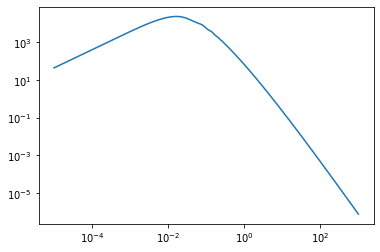

In [2]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=32
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()
flux_true = exp(-uni.final_tau_RSD)[0]

(32, 32, 32)
32768 65 32768
Total run time 1.821772813796997


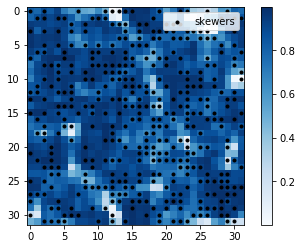

In [4]:
n_los = 400
mock_lya = lya_survey(uni,2,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

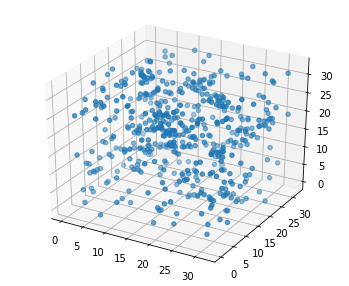

In [5]:
a = 8
mock_gal = gal_survey(uni,a*a) #inverse number density
mock_gal.select_galaxies() #selects galaxies

loc = mock_gal.samples_n #invidual Galaxy locations
fig=figure(figsize=(6,5))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(loc[:,0],loc[:,1],loc[:,2])

In [6]:
flux_obs = mock_lya.vals_observed
flux_contrast = flux_obs/flux_obs.mean()-1

In [7]:
skewers_fin = mock_lya.skewers_fin

In [8]:
1/mock_lya.inverse_covar.values

array([0.44067422, 0.44067422, 0.44067422, ..., 0.25120506, 0.25120506,
       0.25120506], dtype=float32)

In [9]:
p = np.vstack([skewers_fin.T[0], skewers_fin.T[1],skewers_fin.T[2], 1/(mock_lya.inverse_covar.values)**0.5/flux_obs.mean(), flux_contrast]).T
p.tofile("pixel_data.bin")

In [10]:
d_los = n/(n_los)**0.5
l = n
map_n = n
b = d_los
num_pixels = len(skewers_fin.T[0])

In [11]:
d_los

1.6

In [12]:
# write config file
cf = open("run.cfg", "w")
cf.write("lx = %f\n" % l)
cf.write("ly = %f\n" % l)
cf.write("lz = %f\n" % l)
cf.write("num_pixels = %i\n" % num_pixels)
cf.write("map_nx = %i\n" % map_n)
cf.write("map_ny = %i\n" % map_n)
cf.write("map_nz = %i\n" % map_n)
cf.write("corr_var_s = %f\n"%var(flux_obs))
cf.write("corr_l_perp = %f\n" % b)
cf.write("corr_l_para = %f\n" % b)
cf.write("pcg_tol = 1.0e-5/512\n")
cf.write("pcg_max_iter = 1000\n")
cf.close()

In [13]:
!/media/zihao/文档/学习/天体物理/wiener_reconstruction-master/dachshund.exe run.cfg

Reading config file run.cfg.

Running dachshund with:
  pixels/map:
    lx ly lz = 32.000000 32.000000 32.000000
    npix = 12800
    map nx ny nz = 32 32 32, n = 32768
  signal:
    corr var_s = 0.359831
    l_perp = 1.600000    l_para = 1.600000
  WF x solve: 1
  PCG:
    max iter = 1000    step r = 50
    tol = 0.000010
  options:
    map covar = 0
  paths:
    pixel data = pixel_data.bin
    map = map.bin

Reading pixel data.
Preparing for x solve.
Starting solve.
[PCG] Solving 12800 x 12800 problem.
    Goal |r| < (tol) |b| = 1.221203e-03,  delta = 8.084644e+03
    iter 1, |r| 2.022086e+02, delta 1.989515e+04
    iter 2, |r| 1.343193e+02, delta 8.625212e+03
    iter 3, |r| 8.379191e+01, delta 3.363859e+03
    iter 4, |r| 5.732102e+01, delta 1.589055e+03
    iter 5, |r| 3.951295e+01, delta 7.423370e+02
    iter 6, |r| 2.896076e+01, delta 3.951512e+02
    iter 7, |r| 2.160194e+01, delta 2.206694e+02
    iter 8, |r| 1.832947e+01, delta 1.568387e+02
    iter 9, |r| 1.495458e+01, delta

In [14]:
# get the reconstructed file
m = np.fromfile('map.bin')
flux_wiener_recon = (m.reshape(n,n,n)+1)*flux_obs.mean()

In [15]:
# def tf_wiener_kernel(mock_lya):
    
#     data_coords = tf.constant(mock_lya.skewers_fin,dtype=tf.float32)
#     d = mock_lya.vals_observed
#     sigma2 = np.cov(d)
#     d_los = n/np.sqrt(n_los)

#     d = tf.constant(d,shape=(len(d),1),dtype=tf.float32)
#     map_x,map_y,map_z = meshgrid(arange(0,n),arange(0,n),arange(0,n))
#     map_coords = tf.constant(np.vstack(list(map(np.ravel, [map_x,map_y,map_z]))).T,dtype=tf.float32)

#     L_para = d_los
#     L_prep = d_los

#     m_1 = tf.reshape(map_coords[:,0],(-1,1))
#     d_1 = tf.reshape(data_coords[:,0],(-1,1))
#     m_2 = tf.reshape(map_coords[:,1],(-1,1))
#     d_2 = tf.reshape(data_coords[:,1],(-1,1))
#     m_3 = tf.reshape(map_coords[:,2],(-1,1))
#     d_3 = tf.reshape(data_coords[:,2],(-1,1))

#     with tf.device('/cpu:0'):
#         d_1_matrix1 = tf.tile(d_1,[1,d_1.shape[0]])
#         d_1_matrix2 = tf.transpose(d_1_matrix1)

#         d_2_matrix1 = tf.tile(d_2,[1,d_2.shape[0]])
#         d_2_matrix2 = tf.transpose(d_2_matrix1)

#         d_3_matrix1 = tf.tile(d_3,[1,d_3.shape[0]])
#         d_3_matrix2 = tf.transpose(d_3_matrix1)

#         r_prep = (d_1_matrix1-d_1_matrix2)**2+(d_2_matrix1-d_2_matrix2)**2
#         r_para = (d_3_matrix1-d_3_matrix2)**2

#         C_DD = sigma2*tf.exp(-r_para/L_para**2)*tf.exp(-r_prep/L_para**2)

#         m_1_matrix = tf.tile(m_1,[1,d_1.shape[0]])
#         d_1_matrix = tf.transpose(tf.tile(d_1,[1,m_1.shape[0]]))

#         m_2_matrix = tf.tile(m_2,[1,d_2.shape[0]])
#         d_2_matrix = tf.transpose(tf.tile(d_2,[1,m_2.shape[0]]))

#         r_prep = (m_1_matrix-d_1_matrix)**2+(m_2_matrix-d_2_matrix)**2

#         m_3_matrix = tf.tile(m_3,[1,d_3.shape[0]])
#         d_3_matrix = tf.transpose(tf.tile(d_3,[1,m_3.shape[0]]))

#         r_para = (m_3_matrix-d_3_matrix)**2

#         C_MD = sigma2*tf.exp(-r_para/L_para**2)*tf.exp(-r_prep/L_para**2)

#         N_inv = mock_lya.inverse_covar
#         N = tf.sparse.SparseTensor(N_inv.indices,1/N_inv.values,N_inv.dense_shape)
#         N = tf.sparse.to_dense(N)

#         mat_inv = tf.matrix_inverse(C_DD+N)
#         kernel = tf.matmul(C_MD,mat_inv)
        
#     sess = tf.Session()
#     k = sess.run(kernel)
#     return k

In [16]:
# wiener_kernel = tf_wiener_kernel(mock_lya)
# flux_wiener_recon2 = reshape((np.dot(wiener_kernel,flux_contrast)+1)*flux_obs.mean(),(n,n,n))
# flux_wiener_recon2 = array([flux_wiener_recon2[:,i,:] for i in range(n)])

In [17]:
# hist(flux_wiener_recon.flatten(),histtype='step')
# hist(flux_wiener_recon2.flatten(),histtype='step')

In [18]:
def loss(inputs, data, inverse_covar):
    
    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):
    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def opt_recon(mock_lya,k1=2,k2=2,k3=1,clip=True,anneal_steps=[2.5,1.5,1,0.7],maxiter=[50,50,60,30]):
    tf.reset_default_graph()
    lya=mock_lya

    initial=tf.Variable(zeros(shape=(1,n,n,n)),dtype='float32',trainable=True)
    RSD_tau = tf.multiply(initial,1)

    Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
    sum_op = reduce_sum_det

    Rsm = tf.multiply(Rs, 1)
    kvec = fftk((n,n,n), symmetric=False)
    kmesh = __builtin__.sum((np.array(kvec,dtype=object))**2)**0.5
    pkmesh = ipklin(kmesh)

    flux = tf.exp(-RSD_tau)
    flux_s = smoothing(flux,Rsm,kmesh,n)
    yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
    flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

    #The final loss functon we want to minimize
    if clip:
        obj_fun = k1*(loss(flux_val,yy_lya,lya.inverse_covar)+k2*sum_op(tf.square(tf.subtract(flux_s,flux)))
                   +k3*overone(flux))
    else:
        obj_fun = k1*(loss(flux_val,yy_lya,lya.inverse_covar)+k2*sum_op(tf.square(tf.subtract(flux_s,flux))))
               
    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    gtol=1e-5/512
    anneal_steps = [2.5,1.5,1,0.7]
    maxiter = [50,50,60,30]

    time_start = time.time()
    for nn,r0 in enumerate(anneal_steps):
        opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})
        z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
    time_end = time.time()
    print('Total run time %f'%(time_end-time_start))
#     recon_RSD_tau,recon_flux = sess.run([RSD_tau,flux_val],{yy_lya:lya.vals_observed,Rs:[0]})
    recon_RSD_tau= sess.run(RSD_tau,{yy_lya:lya.vals_observed,Rs:[0]})
    return recon_RSD_tau
#     return recon_RSD_tau,recon_flux

In [99]:
tau_opt_recon = opt_recon(mock_lya,1,3,0.5,clip=True)
flux_opt_recon = exp(-tau_opt_recon[0])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 31098.839844
  Number of iterations: 12
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30810.972656
  Number of iterations: 41
  Number of functions evaluations: 65
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 30322.125000
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 29505.300781
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 4.693892


In [21]:
lya_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal, specz_fac=0.0,lya_fac=1.0,pk_fac=0,anneal_steps=[4,3,2,1,0],maxiter=[10,10,10,10,10])  
lya_recon.initmodel()
lya_recon.run_model()

(32, 32, 32)
32768 65 32768
r0,  4
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 146232.421875
  Number of iterations: 10
  Number of functions evaluations: 13
Run Time:  4.6759068965911865
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 144783.265625
  Number of iterations: 10
  Number of functions evaluations: 14
Run Time:  9.11781096458435
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 142030.453125
  Number of iterations: 10
  Number of functions evaluations: 14
Run Time:  13.624274730682373
r0,  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 133477.765625
  Number of iterations: 10
  Number of functions evaluations: 14
Run Time:  1

In [89]:
pk_fac = 0.0

joint_recon = reconstruct_tardis(uni,lya=mock_lya,gal=mock_gal,specz_fac=100.
                                 ,specz_L2=False,lya_fac=1.,pk_fac=pk_fac,
                                 anneal_steps=[5,3,2,0],maxiter=[5,5,5,20])  #initializing with equal weight on galaxy field and lyman alpha field
joint_recon.initmodel()
joint_recon.run_model()

(32, 32, 32)
32768 65 32768
r0,  5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 147339.468750
  Number of iterations: 5
  Number of functions evaluations: 8
Run Time:  3.6136133670806885
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 145166.343750
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  7.331549406051636
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 142475.375000
  Number of iterations: 5
  Number of functions evaluations: 8
Run Time:  12.064109802246094
r0,  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 85724.500000
  Number of iterations: 20
  Number of functions evaluations: 23
Run Time:  18.2812

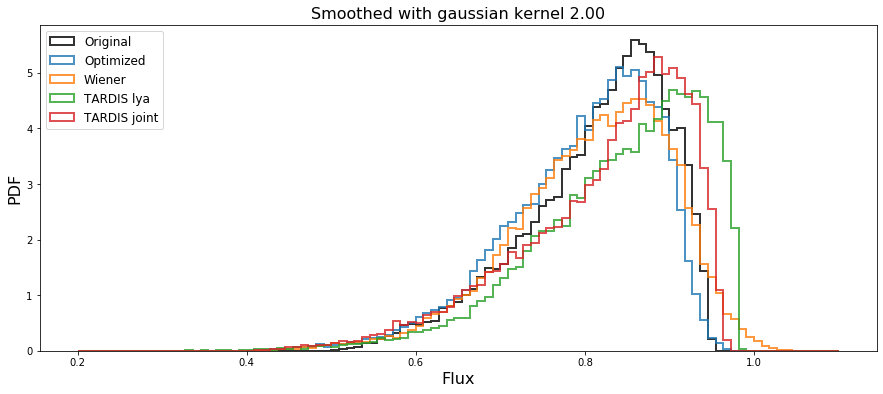

In [100]:
sigma = 2
bins=linspace(0.2,1.1,100)
fig = figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
h_list = {'histtype':'step','linewidth':2,'bins':bins,'alpha':0.8,'density':True}
ax1.hist(ndimage.gaussian_filter(flux_true,sigma).flatten(),label='Original',**h_list,color='black')
ax1.hist(ndimage.gaussian_filter(flux_opt_recon,sigma).flatten(),label='Optimized',**h_list)
ax1.hist(ndimage.gaussian_filter(flux_wiener_recon,sigma).flatten(),label='Wiener',**h_list)
ax1.hist(ndimage.gaussian_filter(exp(-lya_recon.recon_RSD_tau[0]),sigma).flatten(),label='TARDIS lya',**h_list)
ax1.hist(ndimage.gaussian_filter(exp(-joint_recon.recon_RSD_tau[0]),sigma).flatten(),label='TARDIS joint',**h_list)

legend(loc=2,fontsize=12)
ax1.set_ylabel('PDF',fontsize=16)
ax1.set_xlabel('Flux',fontsize=16)
ax1.set_title('Smoothed with gaussian kernel %.2f'%sigma,fontsize=16)
# savefig('flux pdf.png')
show()

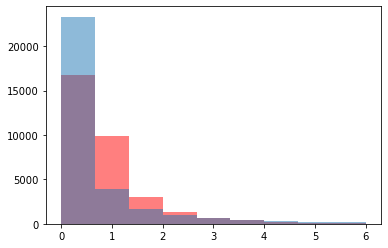

In [96]:
bins = np.linspace(0,6,10)
plt.hist(uni.final_true[0].flatten(),bins=bins,alpha=0.5,color="red")
_=plt.hist(lya_recon.recon_evolved[0].flatten(),bins=bins,alpha=0.5)

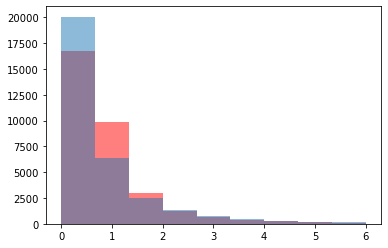

In [94]:
bins = np.linspace(0,6,10)
plt.hist(uni.final_true[0].flatten(),bins=bins,alpha=0.5,color="red")
_=plt.hist(joint_recon.recon_evolved[0].flatten(),bins=bins,alpha=0.5)

In [101]:
flux_tardis_recon = exp(-lya_recon.recon_RSD_tau)[0]

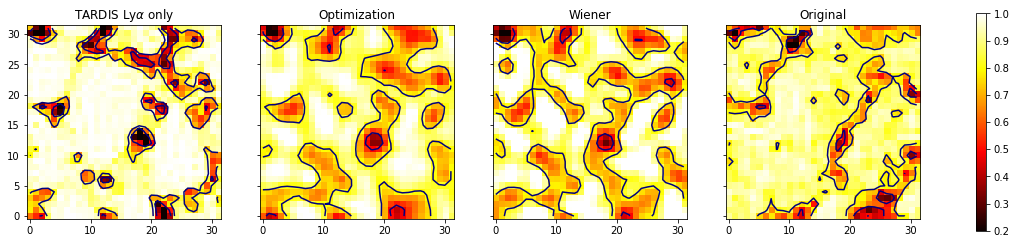

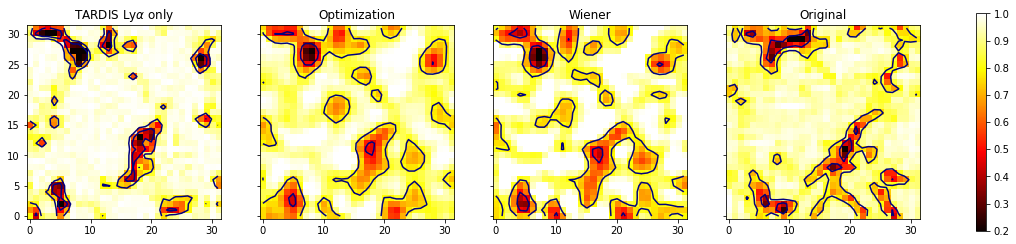

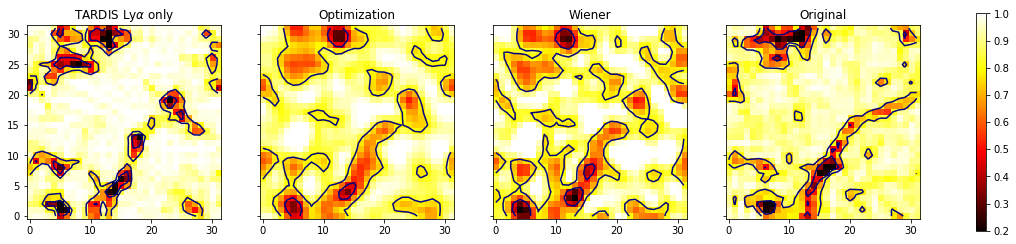

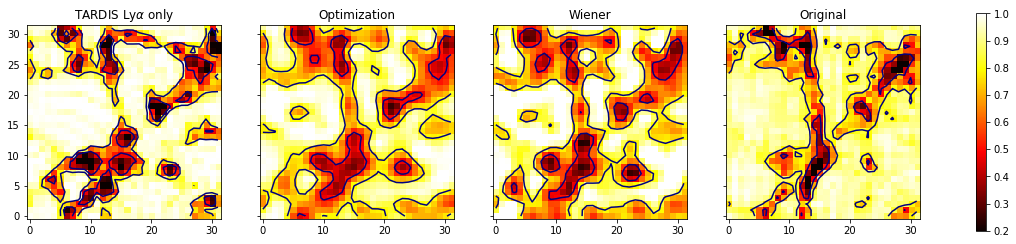

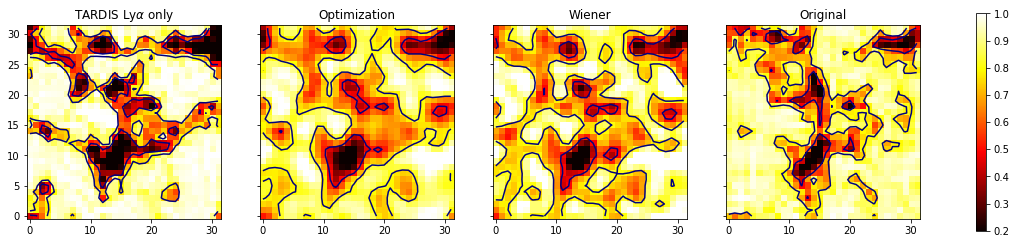

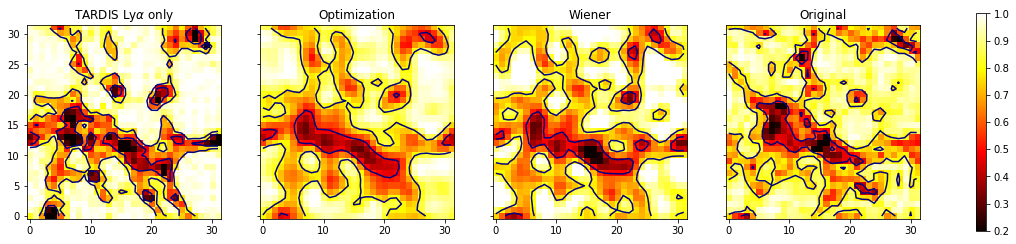

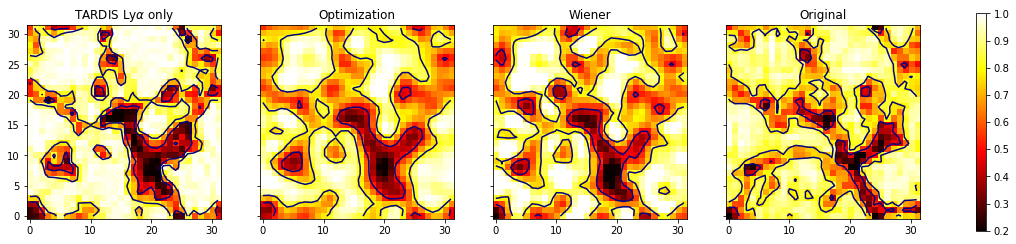

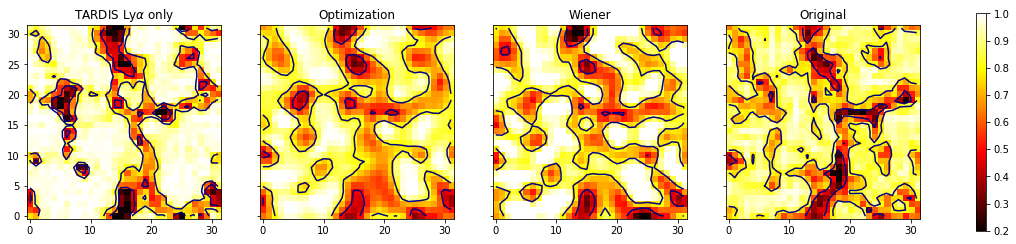

In [102]:
plot_list = {'vmin':0.2,'vmax':1,'cmap':"hot",'origin':'lower'}
con_list = {'levels':[0.5,0.8],'colors':'navy'}

for i in range(n//4):
    fig, ax = plt.subplots(1, 4, sharey='row',figsize=(20,4))

    im1 = ax[0].imshow(flux_tardis_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[0].contour(flux_tardis_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[0].set_title(r'TARDIS Ly$\alpha$ only')

    im2 = ax[1].imshow(flux_opt_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[1].contour(flux_opt_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[1].set_title('Optimization')

    im3 = ax[2].imshow(flux_wiener_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[2].contour(flux_wiener_recon[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[2].set_title('Wiener')
    
    im4 = ax[3].imshow(flux_true[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    con = ax[3].contour(flux_true[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[3].set_title('Original')
    colorbar(im4,ax=ax)
show()


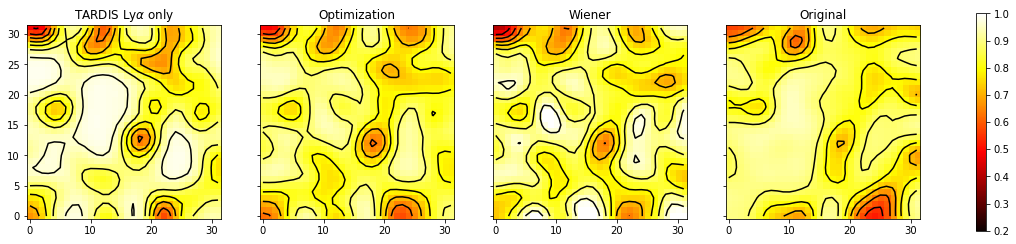

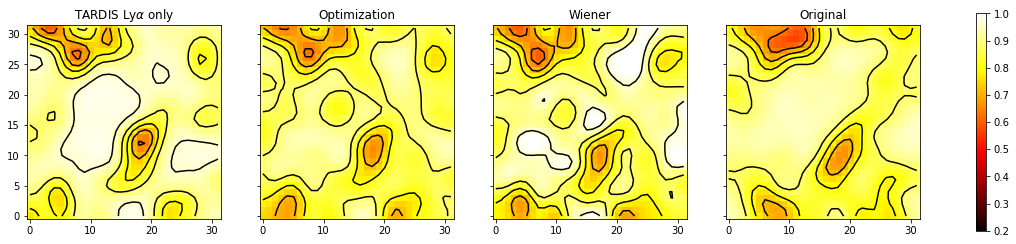

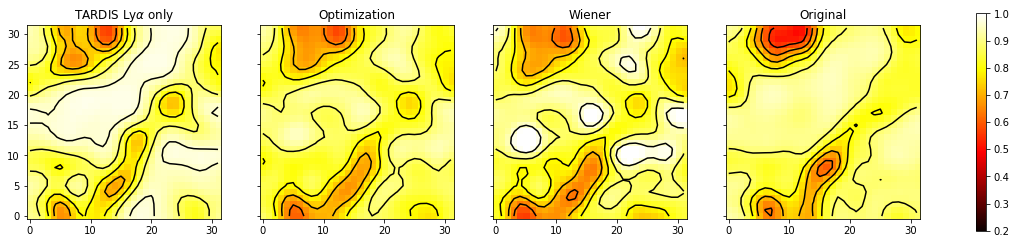

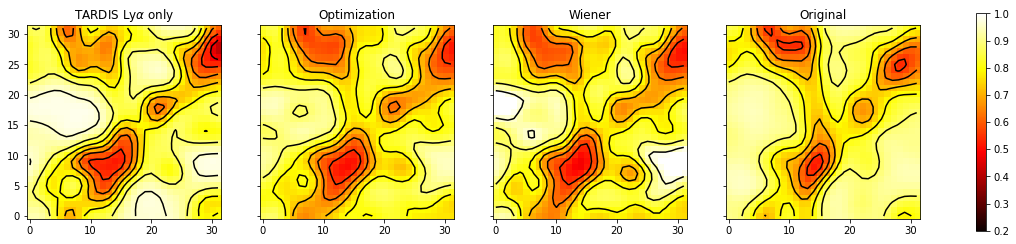

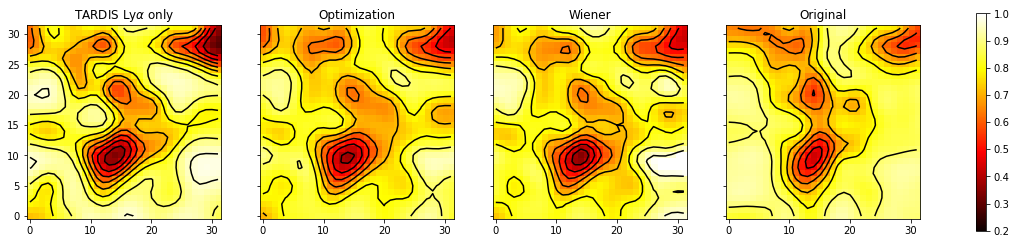

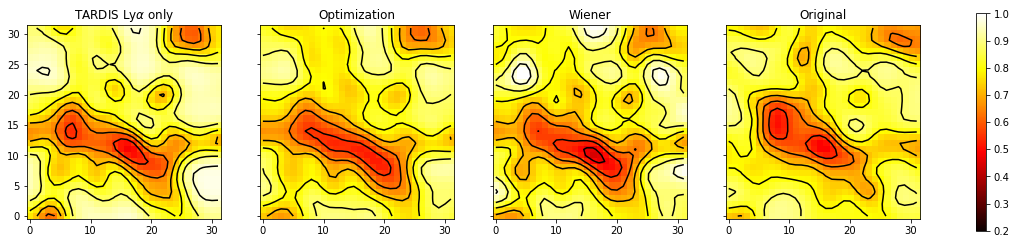

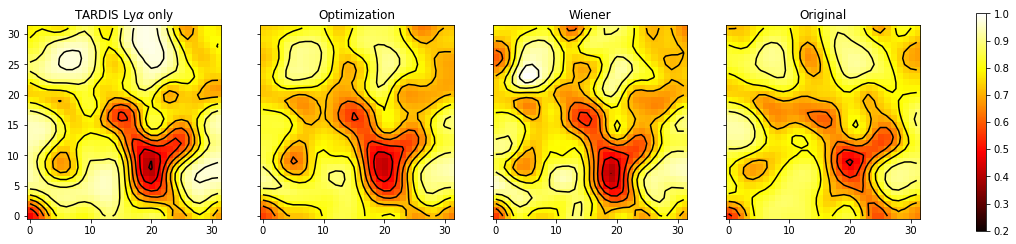

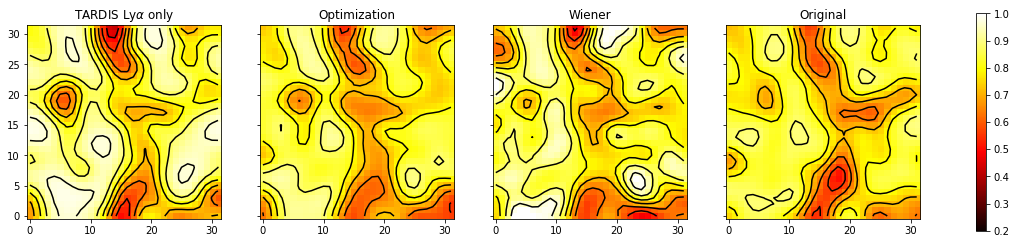

In [27]:
sigma=d_los
plot_list = {'vmin':0.2,'vmax':1,'cmap':"hot",'origin':'lower'}
con_list = {'levels':array([0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88, 0.96]),'colors':'black'}

tardis_sm = ndimage.gaussian_filter(flux_tardis_recon,sigma)
opt_sm = ndimage.gaussian_filter(flux_opt_recon,sigma)
wiener_sm = ndimage.gaussian_filter(flux_wiener_recon,sigma)
true_sm=ndimage.gaussian_filter(flux_true,sigma)

for i in range(n//4):
    fig, ax = plt.subplots(1, 4, sharey='row',figsize=(20,4))

    im1 = ax[0].imshow(tardis_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[0].contour(tardis_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[0].set_title(r'TARDIS Ly$\alpha$ only')

    im2 = ax[1].imshow(opt_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[1].contour(opt_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[1].set_title('Optimization')

    im3 = ax[2].imshow(wiener_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[2].contour(wiener_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[2].set_title('Wiener')
    
    im4 = ax[3].imshow(true_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**plot_list)
    ax[3].contour(true_sm[:,:,4*i:4*(i+1)].sum(axis=2)/4,**con_list)
    ax[3].set_title('Original')
    colorbar(im4,ax=ax)
#     savefig('flux%d'%i)
show()

In [28]:
# linear regression
def linfit(x,y):
    model = linear_model.LinearRegression()
    permutation=np.random.permutation(len(y))
    X=x[permutation]
    Y=y[permutation]

    a = math.floor(3*len(Y)/4)
    train_X = X[:a].reshape(-1,1)
    train_Y = Y[:a].reshape(-1,1)
    test_X = X[a:].reshape(-1,1)
    test_Y = Y[a:].reshape(-1,1)

    model.fit(train_X,train_Y)
    r=model.score(test_X,test_Y)**0.5
    return model,r

In [103]:
sigma = 2

x = ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0]),sigma).flatten()
y1 = ndimage.gaussian_filter(flux_opt_recon,sigma).flatten()
y2 = ndimage.gaussian_filter(flux_wiener_recon,sigma).flatten()
y3 = ndimage.gaussian_filter(flux_tardis_recon,sigma).flatten()

# fit the data, compute slope k and correlation coefficient r.
m1,r1 = linfit(x,y1)
m2,r2 = linfit(x,y2)
m3,r3 = linfit(x,y3)

linx = array([0.4,1.05]).reshape(-1,1)
k1 = ((m1.predict(linx)[1]-m1.predict(linx)[0])/(linx[1]-linx[0]))[0]
k2 = ((m2.predict(linx)[1]-m2.predict(linx)[0])/(linx[1]-linx[0]))[0]
k3 = ((m3.predict(linx)[1]-m3.predict(linx)[0])/(linx[1]-linx[0]))[0]

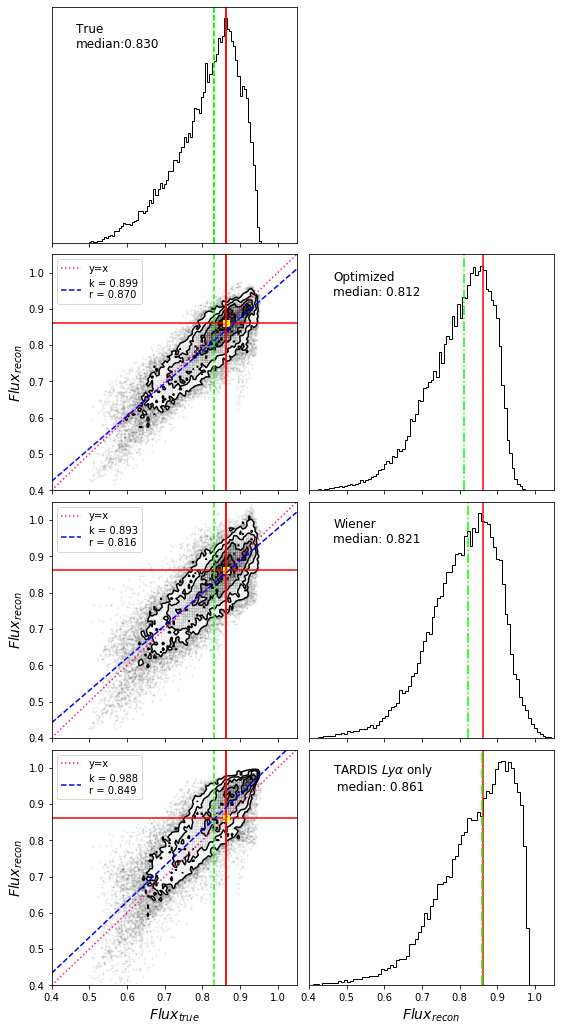

In [104]:
fig,ax = subplots(4,2,figsize=(9,18),sharex='col')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

bins = 80
corner.hist2d(x,y1,ax=ax[1,0],bins=bins)
corner.hist2d(x,y2,ax=ax[2,0],bins=bins)
corner.hist2d(x,y3,ax=ax[3,0],bins=bins)
value,histbin,_= ax[0,0].hist(x,histtype='step',bins=bins,color='k')
_= ax[1,1].hist(y1,histtype='step',bins=bins,color='k')
_= ax[2,1].hist(y2,histtype='step',bins=bins,color='k')
_= ax[3,1].hist(y3,histtype='step',bins=bins,color='k')


a = histbin[where(value==value.max())]+0.5*(histbin[1]-histbin[0])
b=a

q1 = corner.quantile(x,0.5)
q2 = corner.quantile(y1,0.5)
q3 = corner.quantile(y2,0.5)
q4 = corner.quantile(y3,0.5)
q = [q2,q3,q4]

for i in range(4):
    ax[i,1].set_yticks([])
    if i>0:
        ax[i,0].axvline(a,color='red')
        ax[i,0].axhline(b,color='red')
        ax[i,0].set_ylim(0.4,1.05)
        ax[i,0].plot(a,b,'s',c='yellow')
        ax[i,0].set_ylabel(r'$Flux_{recon}$',fontsize=14)
        ax[i,0].plot([0.4,1.05],[0.4,1.05],c='deeppink',linestyle=':',label='y=x')
    for j in range(2):
        ax[i,j].set_xlim(0.4,1.05)
        if j > i:
            ax[i,j].set_frame_on(False)
            ax[i,j].axis('off')
        if (i>0)&(j>0):
            ax[i,j].axvline(a,color='red')
            ax[i,j].axvline(q[i-1],color='lime',linestyle='-.')
        else:
            ax[i,0].axvline(a,color='red')
            ax[i,0].axvline(q1,color='lime',linestyle='--')

ax[1,0].plot(linx,m1.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k1,r1))
ax[1,0].legend(loc=2)
ax[2,0].plot(linx,m2.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k2,r2))
ax[2,0].legend(loc=2)
ax[3,0].plot(linx,m3.predict(linx),c='blue',linestyle='--',label = 'k = %.3f\nr = %.3f'%(k3,r3))
ax[3,0].legend(loc=2)

ax[0,0].set_yticks([])
ax[0,0].set_title('True\nmedian:%.3f'%q1,x=0.1,y=0.8,loc='left')
ax[1,1].set_title('Optimized\nmedian: %.3f'%q2,x=0.1,y=0.8,loc='left')
ax[2,1].set_title('Wiener\nmedian: %.3f'%q3,x=0.1,y=0.8,loc='left')
ax[3,1].set_title(r'TARDIS $Ly\alpha$ only'+ '\n'+' median: %.3f'%q4,x=0.1,y=0.8,loc='left')
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)
ax[3,1].set_xlabel(r'$Flux_{recon}$',fontsize=14)
ax[3,0].set_xlabel(r'$Flux_{true}$',fontsize=14)
savefig('contour.jpg',dpi=100,bbox_inches='tight')

In [31]:
#convert flux to density
def flux_to_density(flux):
    tau = -np.log(flux)
    return (tau/0.226)**(1/1.5)

In [105]:
density_opt = flux_to_density(np.clip(flux_opt_recon,0.0001,1))
density_wiener = flux_to_density(np.clip(flux_wiener_recon,0.0001,1))

Text(0.5, 1.0, 'Smoothed with gaussian kernel $\\sigma$=2')

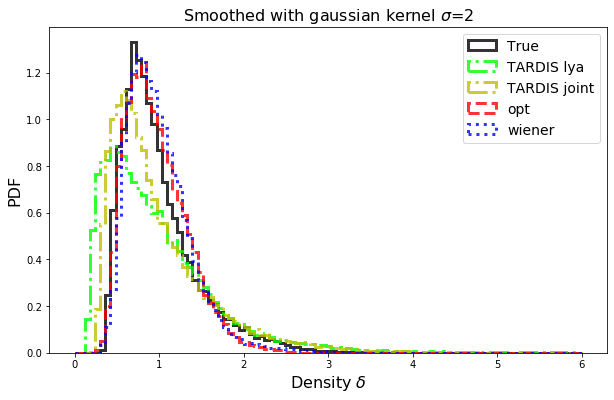

In [158]:
bins = np.linspace(0,6,100)
figure(figsize=(10,6))
sigma = 2
h_list = {'bins':bins,'histtype':'step','linewidth':3,'alpha':0.8,'density':True}
_=hist(ndimage.gaussian_filter(uni.final_true,sigma).flatten(),label='True',**h_list,color='k')
_=hist(ndimage.gaussian_filter(lya_recon.recon_evolved[0],sigma).flatten(),label='TARDIS lya',**h_list,linestyle='-.',color='lime')
_=hist(ndimage.gaussian_filter(joint_recon.recon_evolved[0],sigma).flatten(),label='TARDIS joint',**h_list,linestyle='-.',color='y')

_=hist(ndimage.gaussian_filter(density_opt,sigma).flatten(),label='opt',**h_list,linestyle='--',color='red')
_=hist(ndimage.gaussian_filter(density_wiener,sigma).flatten(),label='wiener',**h_list,linestyle=':',color='blue')
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
ylabel('PDF',fontsize=16)
title('Smoothed with gaussian kernel $\sigma$=2',fontsize=16)
show()

Text(0.5, 1.0, 'Unsmoothed')

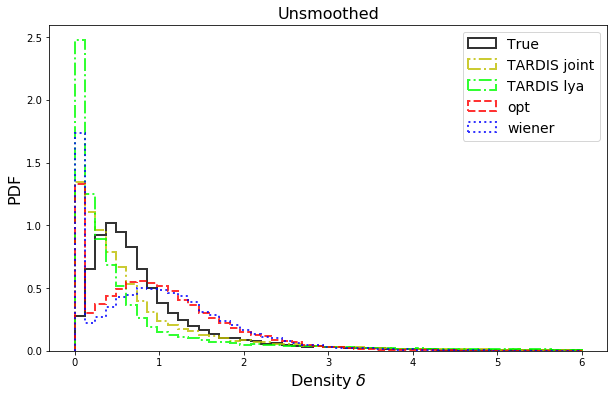

In [157]:
bins = np.linspace(0,6,50)
figure(figsize=(10,6))
h_list = {'bins':bins,'histtype':'step','linewidth':2,'alpha':0.8,'density':True}
_=hist(uni.final_true.flatten(),label='True',**h_list,color='k')
_=hist(joint_recon.recon_evolved[0].flatten(),label='TARDIS joint',**h_list,linestyle='-.',color='y')

_=hist(lya_recon.recon_evolved[0].flatten(),label='TARDIS lya',**h_list,linestyle='-.',color='lime')
_=hist(density_opt.flatten(),label='opt',**h_list,linestyle='--',color='red')
_=hist(density_wiener.flatten(),label='wiener',**h_list,linestyle=':',color='blue')
legend(loc=1,fontsize=14)
xlabel(r'Density $\delta$',fontsize=16)
ylabel('PDF',fontsize=16)
title('Unsmoothed',fontsize=16)
# yscale('log')
show()

In [142]:
def plot_eigenvectors(eigentruth,eigenstuff,
    color_pallete= ["r","b","g","y"],
    center_pallete = ["ro","bx","g*","ys"],
    labels = ["q","q1","q2"],binsize=10):


    plt.figure(figsize=(14,6))

    for ii in range(1,4):
  #  print(ii)
        ax1 = plt.subplot(int("13"+str(ii)))
        #[evals_dm_4,e1_dm,e2_dm,e3_dm]
        for nn,entry in enumerate(eigenstuff):
            print(ii,nn)
            bins, hist_norm = make_hist_norm(np.ndarray.flatten(
                np.abs(np.sum(entry[ii]*eigentruth[ii],axis=3))),binsize=binsize)
            plt.plot(bins,hist_norm,drawstyle='steps-post',color=color_pallete[nn])
            bin_centers = (bins[:-1]+bins[1:])/2.
            hist_centers = hist_norm[:-1]
            plt.plot(bin_centers,hist_centers,center_pallete[nn],ms=5)

        plt.xlabel(r'$\cos\theta$',size=12)

        plt.title(r'$\hat{e}_'+str(ii)+'$',size=16)
        plt.plot(0.1*np.ones(len(bins)),color='k',linestyle='--')
        ax1.set_xlim([0.0,0.99])
        ax1.set_ylim([0.01,1.0])
        plt.minorticks_on()
        plt.yscale('log')

        if ii>1:
            plt.setp(ax1.get_yticklabels(), visible=False)
        if ii==1:

            #Create custom artists
            a1 = plt.Line2D((0,1),(0,0), color='r', marker='o')
            a2 = plt.Line2D((0,1),(0,0), color='b', marker='x')
            a3 = plt.Line2D((0,1),(0,0), color='g', marker='*')
            a4 = plt.Line2D((0,1),(0,0), color='y', marker='s')

            pylab.rcParams['figure.figsize'] = (8.0, 4.0)

            #Create legend from custom artist/label lists
            ax1.legend([a1,a2,a3,a4],
                      labels,loc=2,frameon=False,labelspacing=0.05,
                       bbox_to_anchor=(0,1),handletextpad=0.0,numpoints=1)

            #plt.legend(loc=2,frameon=False,labelspacing=0.15,bbox_to_anchor=(-0.05,1.05),handletextpad=0.0)

            leg = plt.gca().get_legend()
            ltext = leg.get_texts()
            plt.setp(ltext,fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0)

/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0 (32, 32, 32)
1 (32, 32, 32)
2 (32, 32, 32)
3 (32, 32, 32)
1 0
0.8797772416025902
1 1
0.839645984230162
1 2
0.8293164264660922
1 3
0.8518673516438456
2 0
0.7623686664242306
2 1
0.7342158270706354
2 2
0.7082990893638534
2 3
0.7337287669081731
3 0
0.8327212505744893
3 1
0.8275729149281636
3 2
0.7977572773910515
3 3
0.8170220897647531


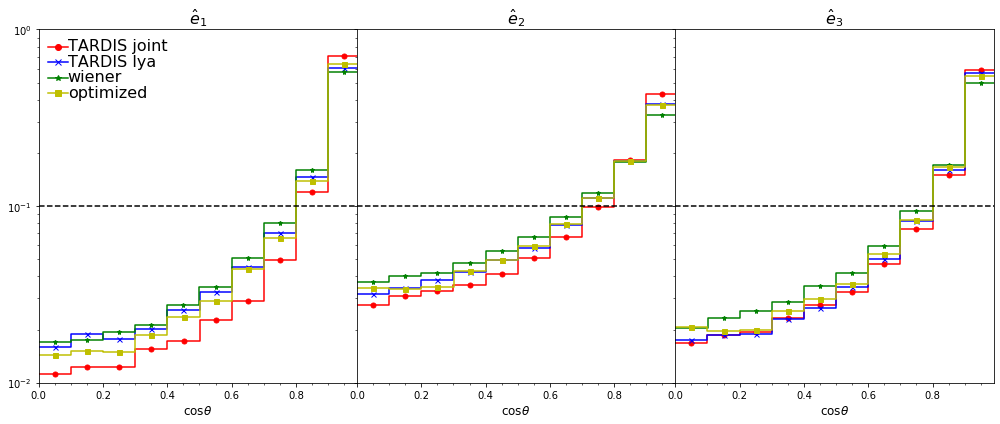

In [144]:
ksize=array([sigma,sigma,sigma,sigma])
a,b = eigen_stuff(uni.final_true[0],
                  [joint_recon.uni_rec.final_true[0],
                   lya_recon.uni_rec.final_true[0],
                   density_wiener,
                   density_opt],
                   kernel_sizes=[1,1,1,1,1],pad = 1, rebin_size=64)
plot_eigenvectors(a,b,labels=["TARDIS joint","TARDIS lya","wiener","optimized"])
# savefig('eigen.png')

In [37]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))    

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap,vmin=0,vmax=1)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           
          )
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontname='Times New Roman',fontsize=14)
    ax.set_ylabel('True',family='Times New Roman',fontsize=16)
    ax.set_xlabel('Predicted',family='Times New Roman',fontsize=16)
    ax.set_title(title,family='Times New Roman',fontsize=16)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [69]:
def classify(e,lam=0.065):
    return sum(e>lam,axis=3).flatten()

In [111]:
truth = uni.final_true[0]
sigma=2
pad=1
dm_density_sm = ndimage.gaussian_filter(truth[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(dm_density_sm)
true_label = classify(e_dm[0])

/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/media/zihao/文档/学习/天体物理/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


In [112]:
len(true_label[true_label==0])/len(true_label)

0.21103703703703705

In [113]:
dm_density_sm = ndimage.gaussian_filter(
    lya_recon.uni_rec.final_true[0][pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(dm_density_sm)
lya_label = classify(e_dm[0])

In [114]:
dm_density_sm = ndimage.gaussian_filter(
    density_wiener[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(dm_density_sm)
wiener_label = classify(e_dm[0])

In [115]:
dm_density_sm = ndimage.gaussian_filter(density_opt[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(dm_density_sm)
opt_label = classify(e_dm[0])

In [149]:
dm_density_sm = ndimage.gaussian_filter(
    joint_recon.uni_rec.final_true[0][pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(dm_density_sm)
joint_label = classify(e_dm[0])

Text(0, 0.5, 'True')

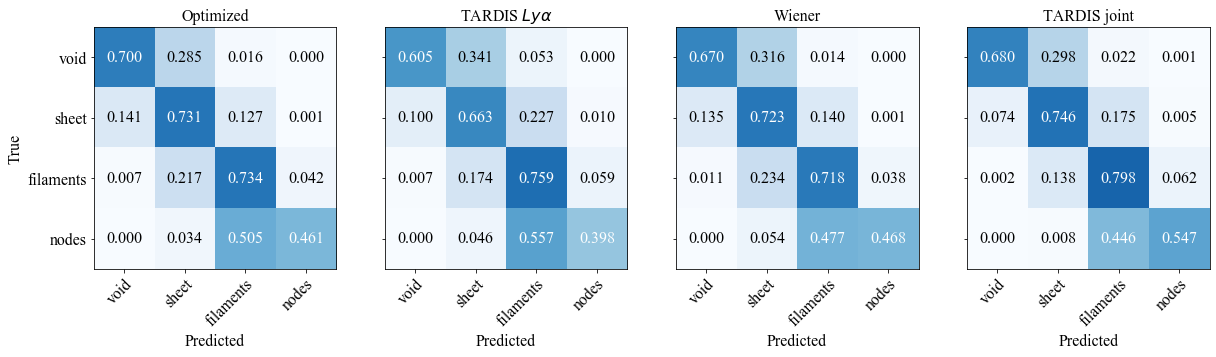

In [151]:
fig, axes = plt.subplots(1,4,sharey='row',figsize=(20,6.5))    

y_true = true_label
titles = ['Optimized',r'TARDIS $Ly\alpha$','Wiener',r'TARDIS joint']
y = [opt_label,lya_label,wiener_label,joint_label]
classes=np.array(["void","sheet","filaments","nodes"])
for i,ax in enumerate(axes):

#     t = titles[i]
    y_pred = y[i]
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues',vmin=0,vmax=1)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
          )
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontname='Times New Roman',fontsize=16)
    ax.set_xlabel('Predicted',family='Times New Roman',fontsize=16)
    ax.set_title(titles[i],family='Times New Roman',fontsize=16)
    # Loop over data dimensions and create text annotations.
    normalize = True
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",family='Times New Roman',fontsize=16)
axes[0].set_ylabel('True',family='Times New Roman',fontsize=16)
# fig.tight_layout()
# savefig('confusion.png')

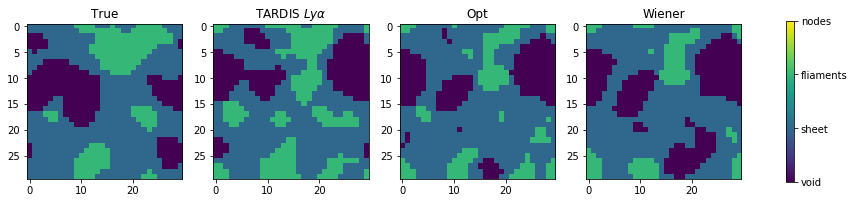

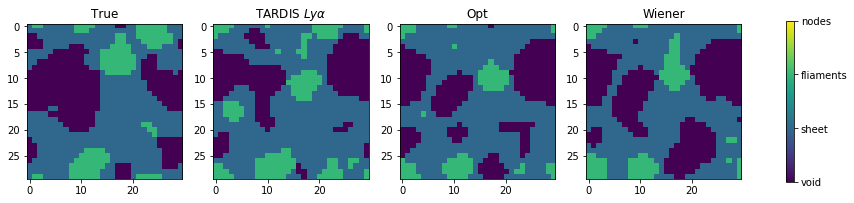

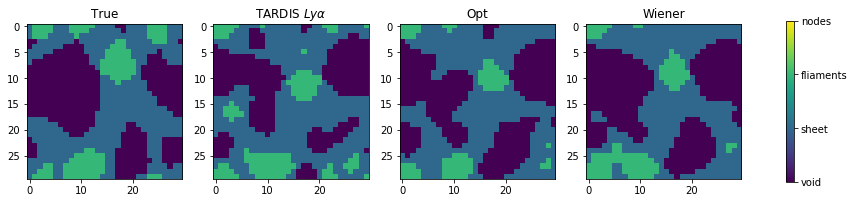

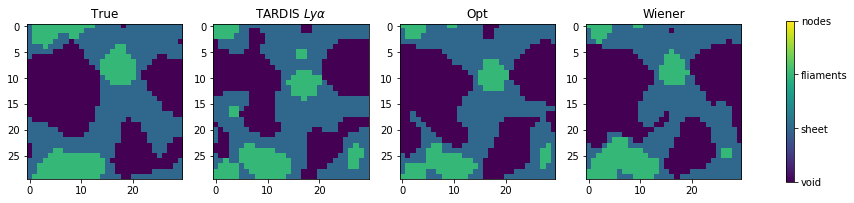

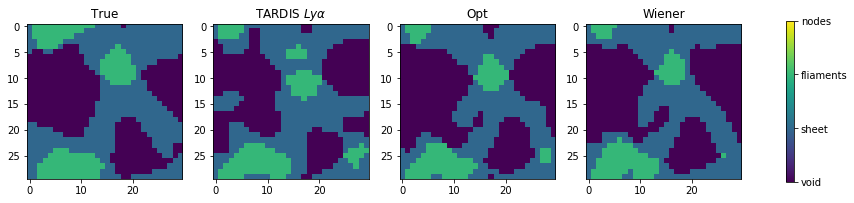

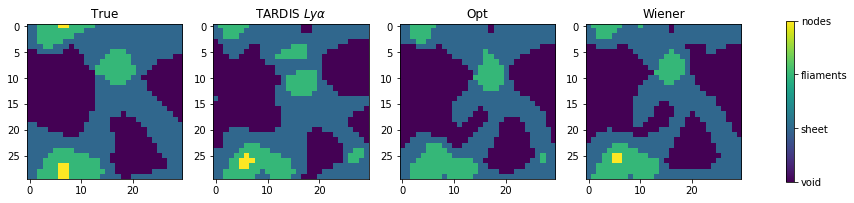

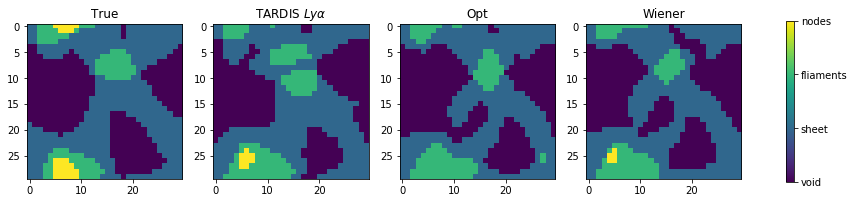

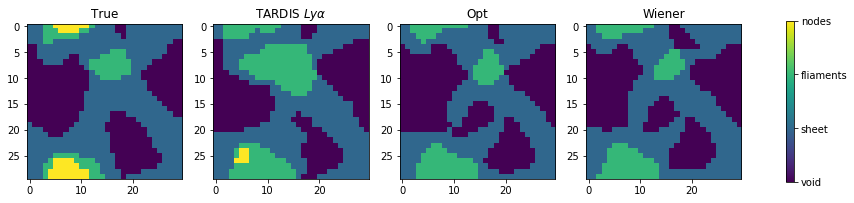

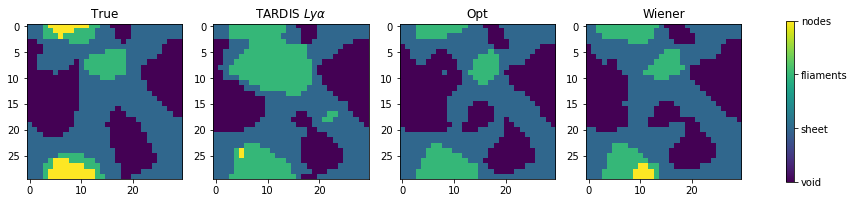

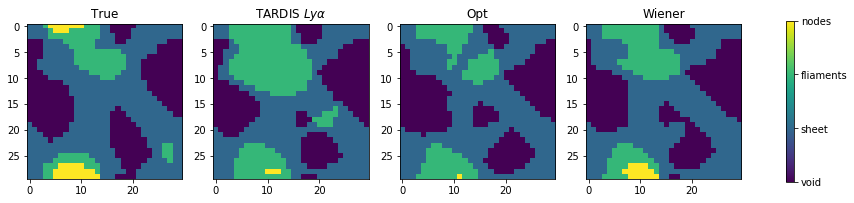

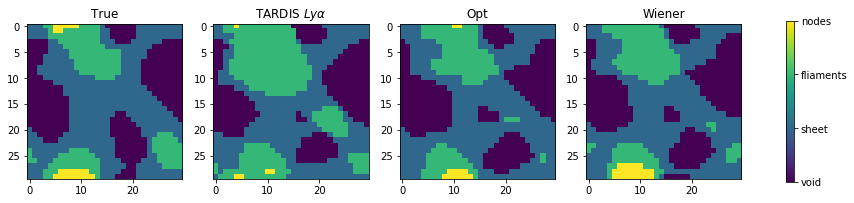

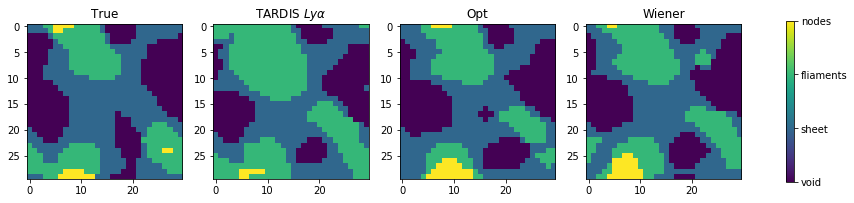

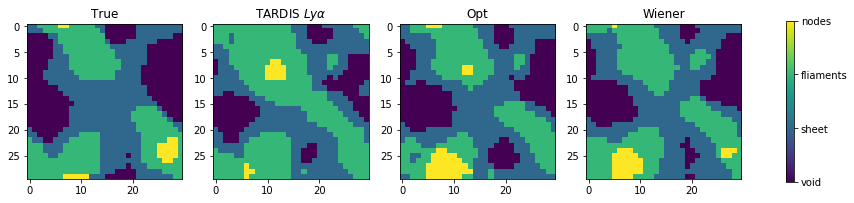

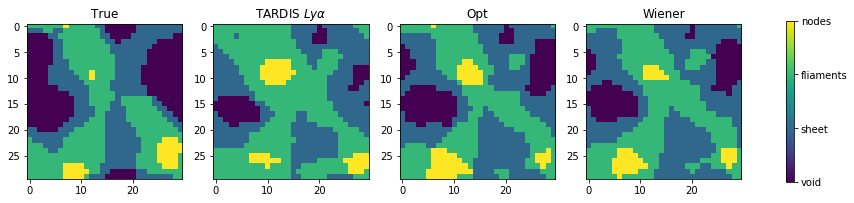

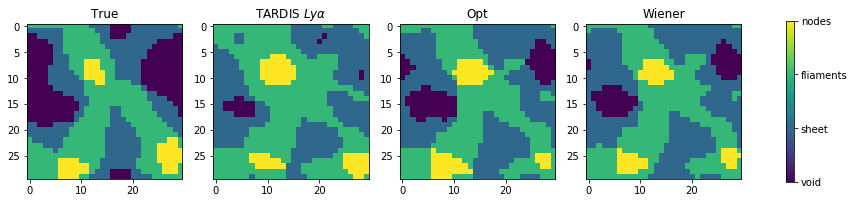

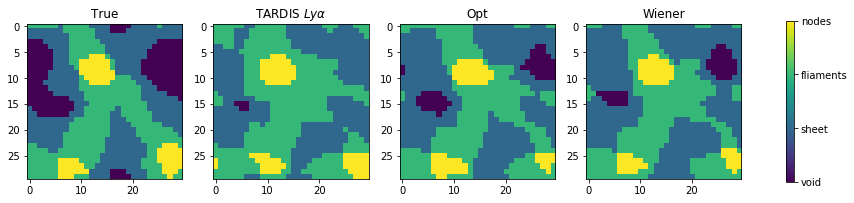

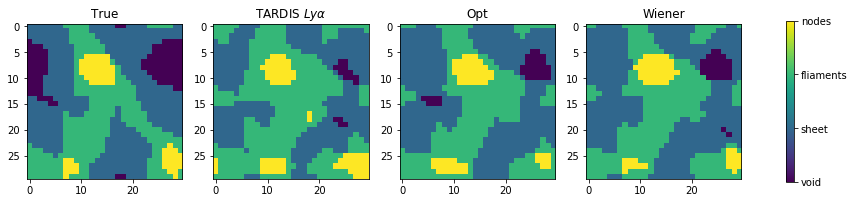

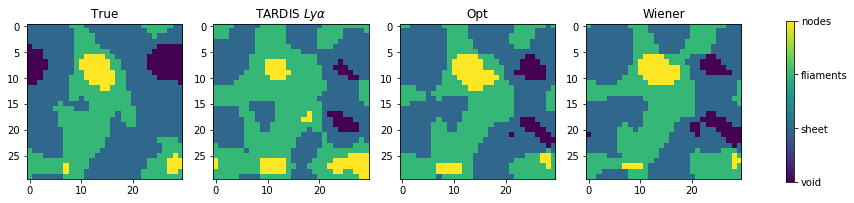

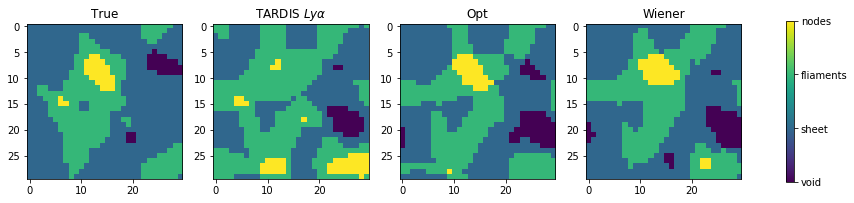

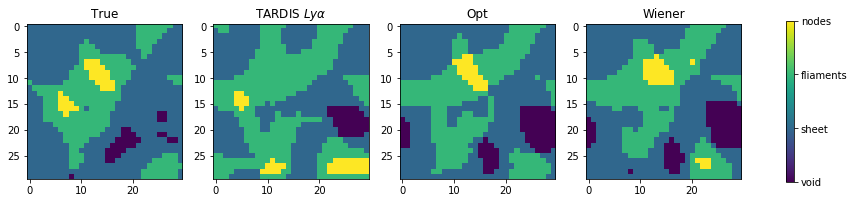

In [117]:
for i in range(20):
    fig=figure(figsize=(16,4))
    ax1 = fig.add_subplot(141)
    # im_list={'cmap':'terrain'}
    ax1.imshow(true_label.reshape(n-2,n-2,n-2)[...,i],vmin=0,vmax=3)
    plt.title('True')
    ax2 = fig.add_subplot(142)
    ax2.imshow(lya_label.reshape(n-2,n-2,n-2)[...,i],vmin=0,vmax=3)
    plt.title(r'TARDIS $Ly\alpha$')
    ax3 = fig.add_subplot(143)
    im3 = ax3.imshow(opt_label.reshape(n-2,n-2,n-2)[...,i],vmin=0,vmax=3)
    plt.title('Opt')
    ax4 = fig.add_subplot(144)
    im4 = ax4.imshow(wiener_label.reshape(n-2,n-2,n-2)[...,i],vmin=0,vmax=3)
    plt.title('Wiener')
    cb=colorbar(im3,ax=[ax1,ax2,ax3,ax4],shrink=.74)
    cb.set_ticks([0,1,2,3])
    cb.set_ticklabels(['void','sheet','fliaments','nodes'])